# **Müşteri Segmentasyonu ve Satış Tahmini Analizi Alt başlık: Online Retail II Veri Seti Üzerinde CLTV**

**Proje Amacı:** Müşteri verilerini kullanarak segmentasyon yapmak ve gelecekteki satışları tahmin etmek

**Veri Seti:** Online Retail II Data Set
İngiliz perakende şirketinin 01/12/2009 - 09/12/2011 arası satış verileri
https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor.

Veri Seti Hikayesi

Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının satışlarını içeriyor.

**Değişkenler**

**InvoiceNo:** Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.

**StockCode:** Ürün kodu. Her bir ürün için eşsiz numara.

**Description:** Ürün ismi

**Quantity:** Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.

**InvoiceDate:** Fatura tarihi ve zamanı.

**UnitPrice:** Ürün fiyatı (Sterlin cinsinden)

**CustomerID:** Eşsiz müşteri numarası

**Country:** Ülke ismi. Müşterinin yaşadığı ülke.

In [ ]:
pip install lifetimes

In [ ]:
pip install plotly_express

In [ ]:
# Gerekli kütüphanelerin kurulumu #
import openpyxl
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df1 = pd.read_csv("/content/Year 2009-2010.csv", encoding="ISO-8859-1")

In [ ]:
df2 = pd.read_csv("/content/Year 2010-2011.csv", encoding="ISO-8859-1")

In [ ]:
df_ = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df = df_.copy()

#Veri Keşfi ve Ön İşleme Veri Temizleme Adımları:

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.2500,13085.0000,United Kingdom


In [ ]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.1000,12680.0000,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.1500,12680.0000,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.1500,12680.0000,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.9500,12680.0000,France
1067370,581587,POST,POSTAGE,1,12/9/2011 12:50,18.0000,12680.0000,France


In [ ]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [ ]:
df.shape

(1067371, 8)

In [ ]:
df.describe()

,Quantity,Price,Customer ID
count,1067371.0000,1067371.0000,824364.0000
mean,9.9389,4.6494,15324.6385
std,172.7058,123.5531,1697.4645
min,-80995.0000,-53594.3600,12346.0000
25%,1.0000,1.2500,13975.0000
50%,3.0000,2.1000,15255.0000
75%,10.0000,4.1500,16797.0000
max,80995.0000,38970.0000,18287.0000


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0000,9.9389,172.7058,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,1067371.0000,4.6494,123.5531,-53594.3600,1.2500,2.1000,4.1500,38970.0000
Customer ID,824364.0000,15324.6385,1697.4645,12346.0000,13975.0000,15255.0000,16797.0000,18287.0000


DataFrame İçinde Eksik Değer Kontrolü

In [ ]:
df.isna().any()

Invoice        False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
Price          False
Customer ID     True
Country        False
dtype: bool

DataFrame'deki Boş Değer Sayımı

In [ ]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

**Eksik değerlerin kaldırılması İade işlemlerinin (C ile başlayan faturalar) filtrelenmesi Negatif miktar ve fiyatların kaldırılması Aykırı değerler için eşik değerlerin uygulanması**

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:

df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")
# Totalprice sütunu eklendi
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [ ]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64

**Toplam Satılan Ürün Sayısı**

In [ ]:
df['Quantity'].sum()

9538576.0

**En çok satılan 10 ürünün listelenmesi, görselleştirilmesi**

In [ ]:
data = df.groupby('Description')['Quantity'].sum().reset_index()
data = data.rename(columns={'Description': 'Product_name', 'Quantity': 'Total_Quantity'})
data = data.sort_values(by='Total_Quantity', ascending=False).head(10)
data

,Product_name,Total_Quantity
5047,WHITE HANGING HEART T-LIGHT HOLDER,85139.0000
2392,JUMBO BAG RED RETROSPOT,72199.5000
5168,WORLD WAR 2 GLIDERS ASSTD DESIGNS,72111.5000
292,ASSORTED COLOUR BIRD ORNAMENT,70002.5000
157,60 TEATIME FAIRY CAKE CASES,50034.0000
3065,PACK OF 60 PINK PAISLEY CAKE CASES,47429.5000
3067,PACK OF 72 RETRO SPOT CAKE CASES,42332.0000
3068,PACK OF 72 RETROSPOT CAKE CASES,39683.0000
1113,COLOUR GLASS T-LIGHT HOLDER HANGING,36791.0000
2760,MINI PAINT SET VINTAGE,35395.0000


<ipython-input-245-3f7d8c6bae58>:3: UserWarning:


The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.



Text(0.5, 1.0, 'Top 10 products by quantity')

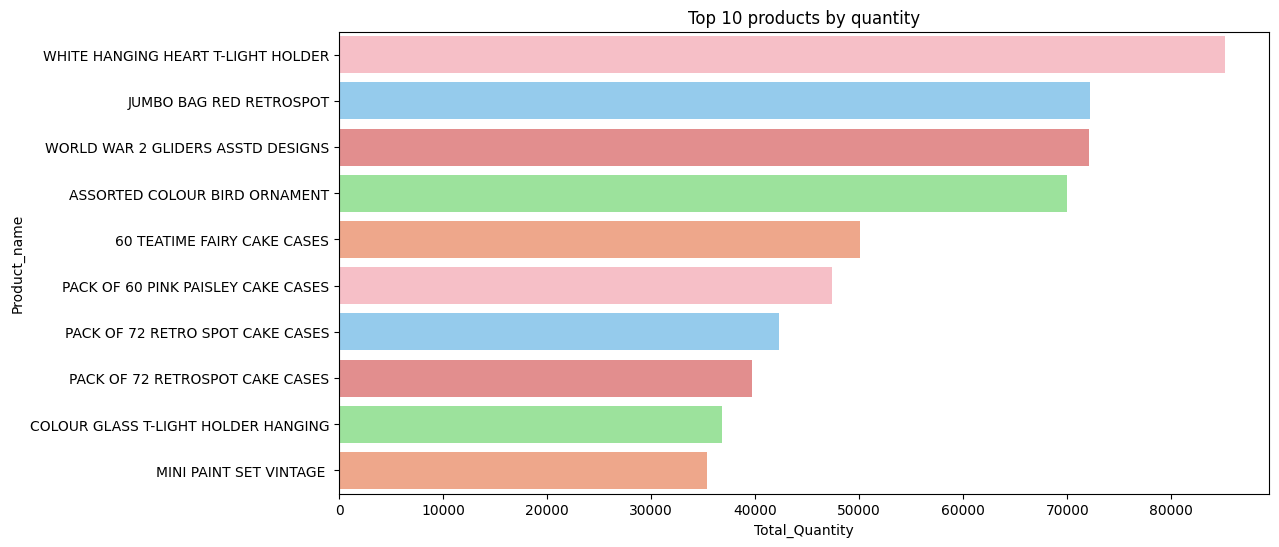

In [ ]:
custom_palette = ["lightpink", "lightskyblue", "lightcoral", "lightgreen", "lightsalmon"]
plt.figure(figsize=(12,6))
sns.barplot(x=data['Total_Quantity'],y=data['Product_name'], palette=custom_palette)
plt.title('Top 10 products by quantity')

**En az satılan 10 ürün**

In [ ]:
data_ = df.groupby('Description')['Quantity'].sum().reset_index()
data_ = data.rename(columns={'Description': 'Product_name', 'Quantity': 'Total_Quantity'})
data_ = data.sort_values(by='Total_Quantity', ascending=False).tail(10)
data_

,Product_name,Total_Quantity
5047,WHITE HANGING HEART T-LIGHT HOLDER,85139.0000
2392,JUMBO BAG RED RETROSPOT,72199.5000
5168,WORLD WAR 2 GLIDERS ASSTD DESIGNS,72111.5000
292,ASSORTED COLOUR BIRD ORNAMENT,70002.5000
157,60 TEATIME FAIRY CAKE CASES,50034.0000
3065,PACK OF 60 PINK PAISLEY CAKE CASES,47429.5000
3067,PACK OF 72 RETRO SPOT CAKE CASES,42332.0000
3068,PACK OF 72 RETROSPOT CAKE CASES,39683.0000
1113,COLOUR GLASS T-LIGHT HOLDER HANGING,36791.0000
2760,MINI PAINT SET VINTAGE,35395.0000


**Benzersiz Ülke Adları ve Toplam Ülke Sayısı**

In [ ]:
print(df['Country'].unique())
print(df["Country"].nunique())

['United Kingdom' 'France' 'USA' 'Belgium' 'Australia' 'EIRE' 'Germany'
 'Portugal' 'Denmark' 'Netherlands' 'Poland' 'Channel Islands' 'Spain'
 'Cyprus' 'Greece' 'Norway' 'Austria' 'Sweden' 'United Arab Emirates'
 'Finland' 'Italy' 'Switzerland' 'Japan' 'Unspecified' 'Nigeria' 'Malta'
 'RSA' 'Singapore' 'Bahrain' 'Thailand' 'Israel' 'Lithuania' 'West Indies'
 'Korea' 'Brazil' 'Canada' 'Iceland' 'Lebanon' 'Saudi Arabia'
 'Czech Republic' 'European Community']
41


**En çok alışveriş yapan 5 ülke**

In [ ]:
countries = df['Country'].value_counts()[:5]

for country, count in countries.items():
    print(f"Ülke: {country}, Toplam Sayı: {count}")

Ülke: United Kingdom, Toplam Sayı: 725250
Ülke: Germany, Toplam Sayı: 16694
Ülke: EIRE, Toplam Sayı: 15743
Ülke: France, Toplam Sayı: 13812
Ülke: Netherlands, Toplam Sayı: 5088


**Ülke başına verilen sipariş sayısı**

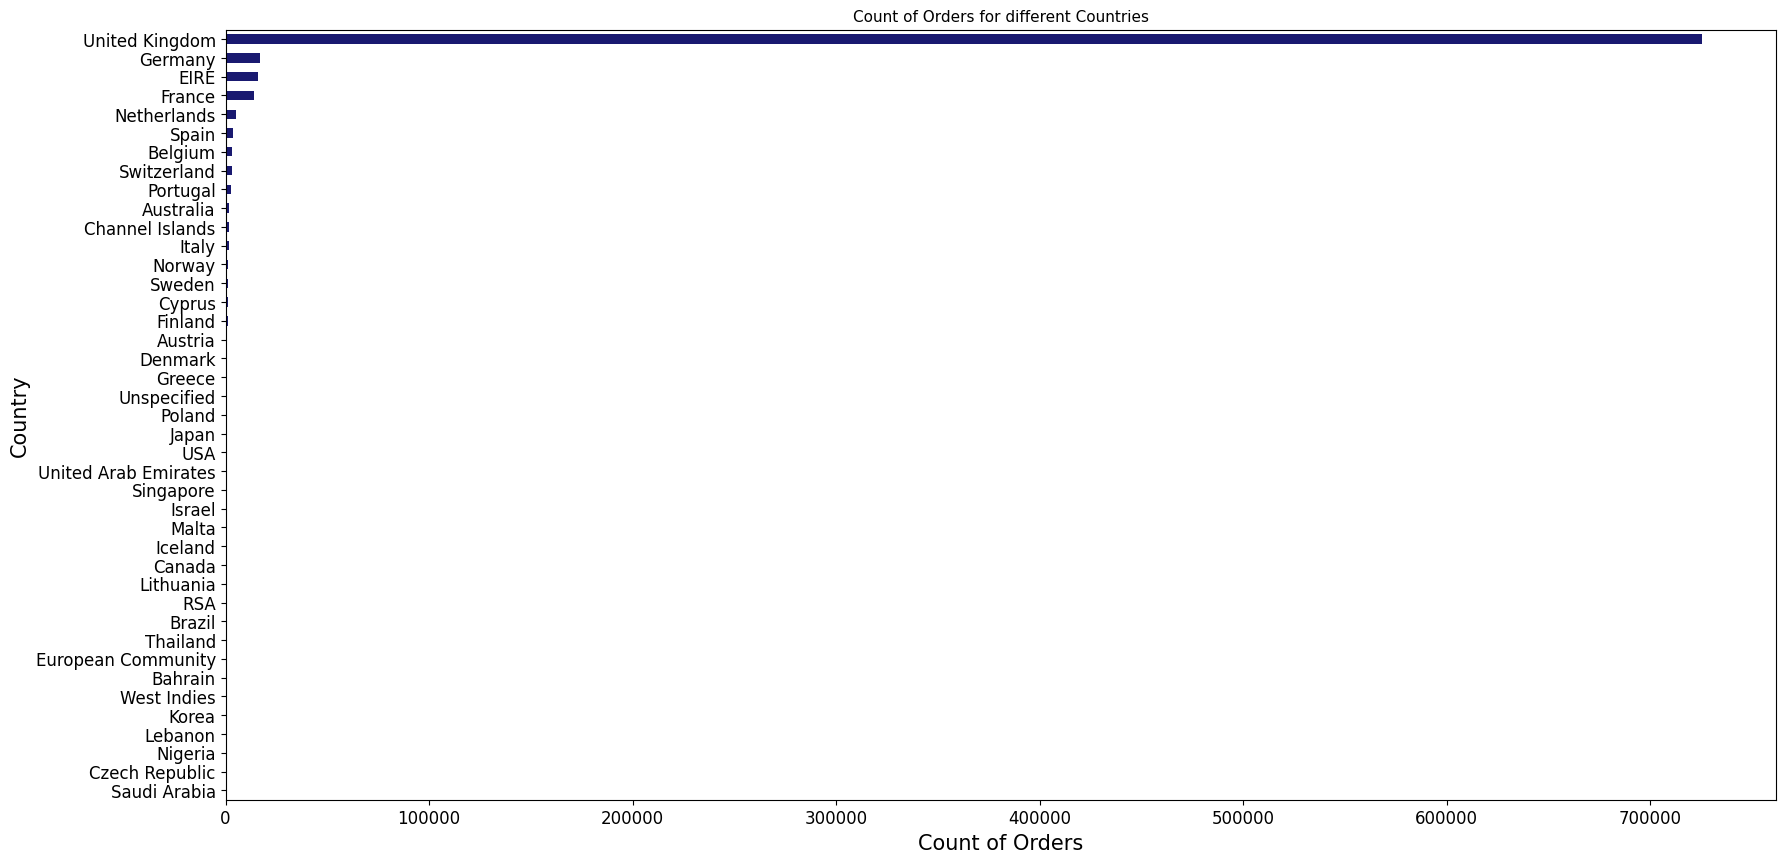

In [ ]:

group_country = df.groupby('Country')['Invoice'].count().sort_values()

plt.subplots(figsize=(20,10))
group_country.plot(kind = 'barh', fontsize=12,color='midnightblue')
plt.xlabel('Count of Orders', fontsize=15)
plt.ylabel('Country', fontsize=15)
plt.title('Count of Orders for different Countries', fontsize=11)
plt.show()

**UK(Birleşik Krallık) dışındaki ülkelerin sipariş sayısı**

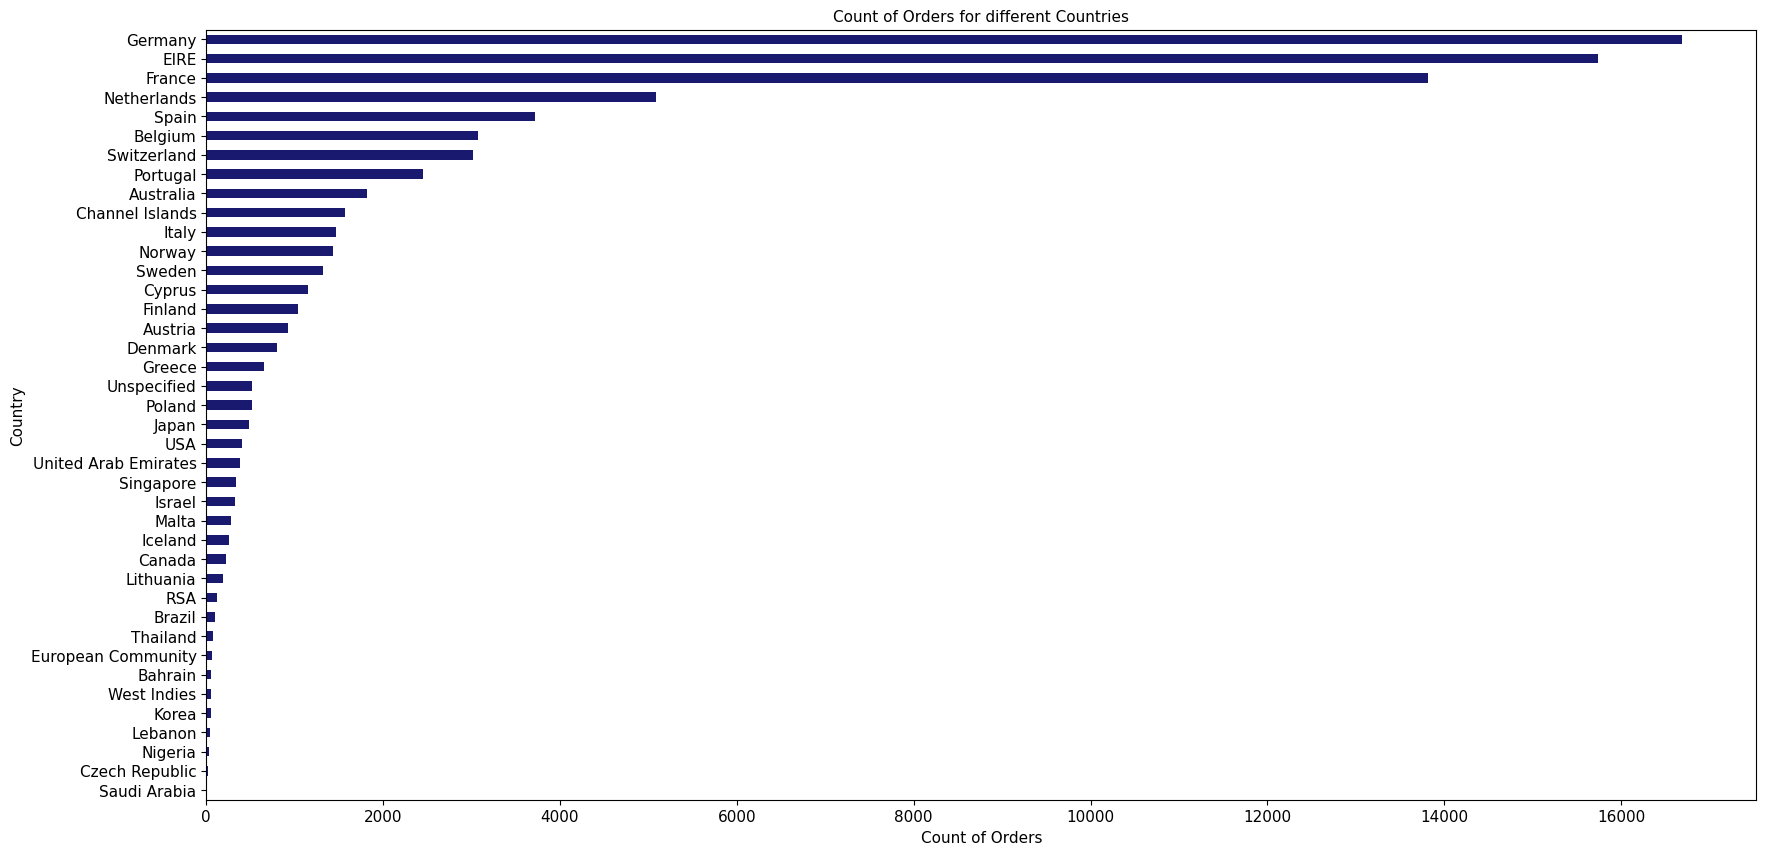

In [ ]:
group_country = df.groupby('Country')['Invoice'].count().sort_values()
del group_country['United Kingdom']

plt.subplots(figsize=(20,10))
group_country.plot(kind = 'barh', fontsize=11,color='midnightblue')
plt.xlabel('Count of Orders', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Count of Orders for different Countries', fontsize=11)
plt.show()

**Tüm ülkeler üzerinden müşteri tarafından ödenen ortalama tutarı hesaplama**

In [ ]:
df_country_avg = df.copy()

df_country_avg['TotalAmount'] = df_country_avg['Quantity'] * df_country_avg['Price']

avg_amount_by_country = df_country_avg.groupby('Country')['TotalAmount'].mean().reset_index()

fig = px.bar(avg_amount_by_country, x='Country', y='TotalAmount', title='Average Amount Paid by the Customer by Country')
fig.update_xaxes(categoryorder='total descending')

fig.show()


**En çok iade/iptal işleminde bulunan ülkeler**

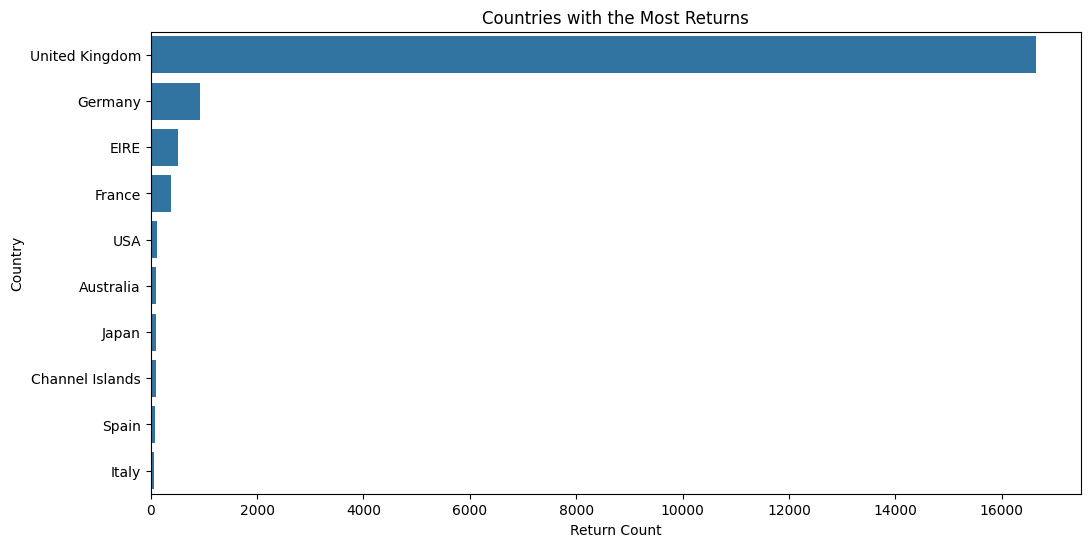

In [ ]:
returned_orders = df_[df_['Invoice'].str.contains('C', na=False)]

returns_by_country = returned_orders.groupby('Country').size().reset_index(name='ReturnCount')

returns_by_country = returns_by_country.sort_values('ReturnCount', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='ReturnCount', y='Country', data=returns_by_country.head(10))
plt.title('Countries with the Most Returns')
plt.xlabel('Return Count')
plt.ylabel('Country')
plt.show()

**En çok iade edilen ürünler**

In [ ]:
returned_orders = df_[df_['Invoice'].str.contains('C', na=False)]

returns_by_product = returned_orders.groupby(['StockCode', 'Description']).size().reset_index(name='ReturnCount')

returns_by_product = returns_by_product.sort_values('ReturnCount', ascending=False)

returns_by_product = returns_by_product[returns_by_product['StockCode'] != ('M')]
returns_by_product = returns_by_product[returns_by_product['StockCode'] != ('POST')]
returns_by_product = returns_by_product[returns_by_product['StockCode'] != ('D')]
returns_by_product = returns_by_product[returns_by_product['StockCode'] != ('S')]
returns_by_product.reset_index(drop=True, inplace=True)

returns_by_product

,StockCode,Description,ReturnCount
0,22423,REGENCY CAKESTAND 3 TIER,347
1,22138,BAKING SET 9 PIECE RETROSPOT,211
2,21232,STRAWBERRY CERAMIC TRINKET BOX,184
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,135
4,79323W,WHITE CHERRY LIGHTS,121
...,...,...,...
3079,21274,EMBOSSED HEART 3 DRAWER SHELF,1
3080,22466,FAIRY TALE COTTAGE NIGHT LIGHT,1
3081,21280,VINTAGE KITCHEN PRINT VEGETABLES,1
3082,21281,VINTAGE KITCHEN PRINT SEAFOOD,1


**En çok iade edilen 10 ürün**

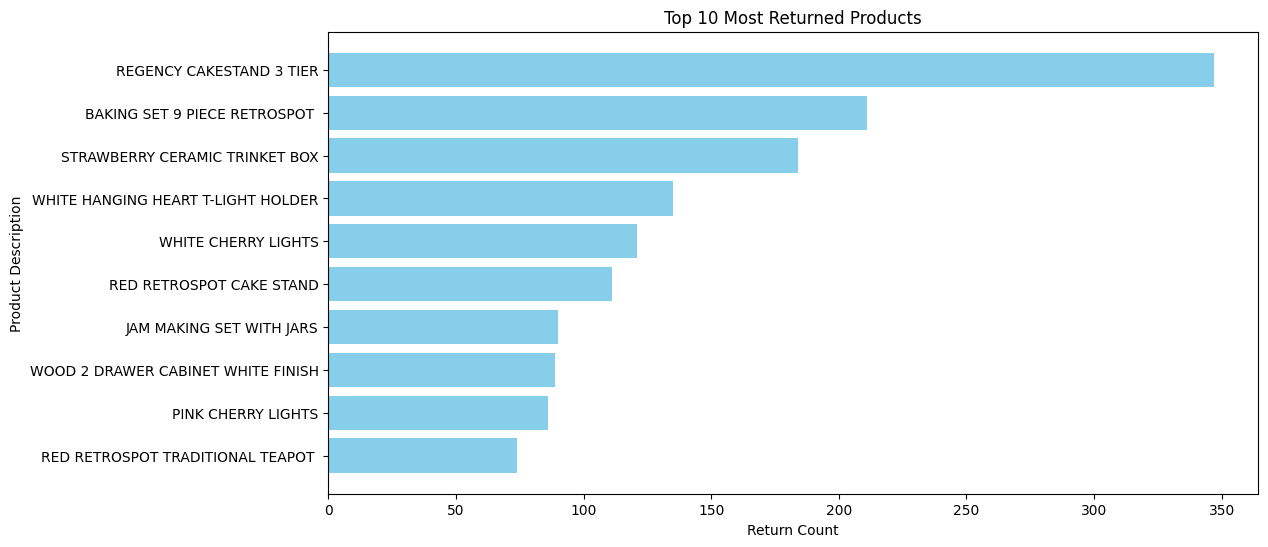

In [ ]:
top_10_returns = returns_by_product.head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_10_returns['Description'], top_10_returns['ReturnCount'], color='skyblue')
plt.xlabel('Return Count')
plt.ylabel('Product Description')
plt.title('Top 10 Most Returned Products')
plt.gca().invert_yaxis()
plt.show()


**Birleşik Krallık müşterilerinden haftalık, aylık ve üç aylık olarak elde edilen kârların görselleştirilmesi**

In [ ]:
uk_customers = df[df['Country'] == 'United Kingdom']
uk_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0000,12/1/2009 7:45,6.9500,13085.0000,United Kingdom,83.4000
1,489434,79323P,PINK CHERRY LIGHTS,12.0000,12/1/2009 7:45,6.7500,13085.0000,United Kingdom,81.0000
2,489434,79323W,WHITE CHERRY LIGHTS,12.0000,12/1/2009 7:45,6.7500,13085.0000,United Kingdom,81.0000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0000,12/1/2009 7:45,2.1000,13085.0000,United Kingdom,100.8000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0000,12/1/2009 7:45,1.2500,13085.0000,United Kingdom,30.0000


In [ ]:
uk_customers['InvoiceDate'] = pd.to_datetime(uk_customers['InvoiceDate'])

uk_customers['Week'] = uk_customers['InvoiceDate'].dt.isocalendar().week
uk_customers['Month'] = uk_customers['InvoiceDate'].dt.month
uk_customers['Quarter'] = uk_customers['InvoiceDate'].dt.quarter
uk_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Week,Month,Quarter
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0000,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom,83.4000,49,12,4
1,489434,79323P,PINK CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000,49,12,4
2,489434,79323W,WHITE CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000,49,12,4
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0000,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom,100.8000,49,12,4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0000,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom,30.0000,49,12,4


In [ ]:
uk_customers['Profit'] = uk_customers['Quantity'] * uk_customers['Price']

weekly_profits = uk_customers.groupby('Week')['Profit'].sum()
monthly_profits = uk_customers.groupby('Month')['Profit'].sum()
quarterly_profits = uk_customers.groupby('Quarter')['Profit'].sum()

weekly_profits.head()

Week
1   200231.8650
2   192188.8550
3   146219.6710
4   179711.6610
5   181492.3570
Name: Profit, dtype: float64

In [ ]:
monthly_profits.head()


Month
1    730715.0370
2    746474.3910
3   1006320.3010
4    876293.7370
5   1007197.9400
Name: Profit, dtype: float64

In [ ]:
quarterly_profits.head()

Quarter
1   2483509.7290
2   2865902.8770
3   3307607.8490
4   5126429.2670
Name: Profit, dtype: float64

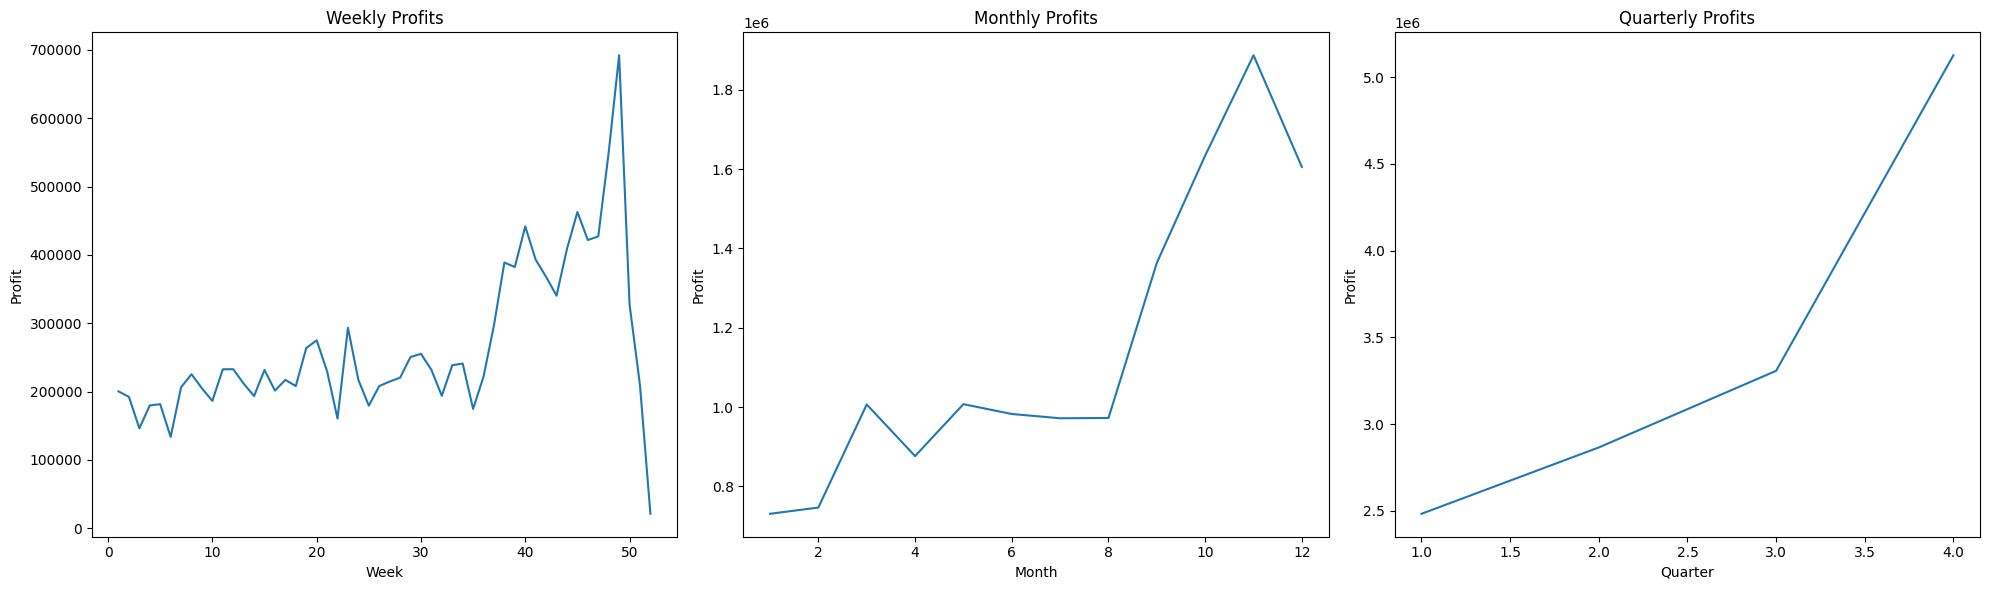

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(weekly_profits.index, weekly_profits.values)
plt.title('Weekly Profits')
plt.xlabel('Week')
plt.ylabel('Profit')

plt.subplot(1, 3, 2)
plt.plot(monthly_profits.index, monthly_profits.values)
plt.title('Monthly Profits')
plt.xlabel('Month')
plt.ylabel('Profit')

plt.subplot(1, 3, 3)
plt.plot(quarterly_profits.index, quarterly_profits.values)
plt.title('Quarterly Profits')
plt.xlabel('Quarter')
plt.ylabel('Profit')

plt.tight_layout()
plt.show()

**Birleşik Krallık dışındaki müşterilerden haftalık, aylık ve üç aylık olarak elde edilen kârları görselleştirilmesi**

In [ ]:
non_uk_customers = df[df['Country'] != 'United Kingdom']
non_uk_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
71,489439,22065,CHRISTMAS PUDDING TRINKET POT,12.0000,12/1/2009 9:28,1.4500,12682.0000,France,17.4000
72,489439,22138,BAKING SET 9 PIECE RETROSPOT,9.0000,12/1/2009 9:28,4.9500,12682.0000,France,44.5500
73,489439,22139,RETRO SPOT TEA SET CERAMIC 11 PC,9.0000,12/1/2009 9:28,4.9500,12682.0000,France,44.5500
74,489439,22352,LUNCHBOX WITH CUTLERY RETROSPOT,12.0000,12/1/2009 9:28,2.5500,12682.0000,France,30.6000
75,489439,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,3.0000,12/1/2009 9:28,5.9500,12682.0000,France,17.8500


In [ ]:
non_uk_customers['InvoiceDate'] = pd.to_datetime(non_uk_customers['InvoiceDate'])

non_uk_customers['Week'] = non_uk_customers['InvoiceDate'].dt.isocalendar().week
non_uk_customers['Month'] = non_uk_customers['InvoiceDate'].dt.month
non_uk_customers['Quarter'] = non_uk_customers['InvoiceDate'].dt.quarter
non_uk_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Week,Month,Quarter
71,489439,22065,CHRISTMAS PUDDING TRINKET POT,12.0000,2009-12-01 09:28:00,1.4500,12682.0000,France,17.4000,49,12,4
72,489439,22138,BAKING SET 9 PIECE RETROSPOT,9.0000,2009-12-01 09:28:00,4.9500,12682.0000,France,44.5500,49,12,4
73,489439,22139,RETRO SPOT TEA SET CERAMIC 11 PC,9.0000,2009-12-01 09:28:00,4.9500,12682.0000,France,44.5500,49,12,4
74,489439,22352,LUNCHBOX WITH CUTLERY RETROSPOT,12.0000,2009-12-01 09:28:00,2.5500,12682.0000,France,30.6000,49,12,4
75,489439,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,3.0000,2009-12-01 09:28:00,5.9500,12682.0000,France,17.8500,49,12,4


In [ ]:
non_uk_customers['Profit'] = non_uk_customers['Quantity'] * non_uk_customers['Price']

non_uk_weekly_profits = non_uk_customers.groupby('Week')['Profit'].sum()
non_uk_monthly_profits = non_uk_customers.groupby('Month')['Profit'].sum()
non_uk_quarterly_profits = non_uk_customers.groupby('Quarter')['Profit'].sum()

non_uk_weekly_profits.head()

Week
1   68394.9050
2   56693.6950
3   61214.2800
4   54890.5650
5   32253.3200
Name: Profit, dtype: float64

In [ ]:
non_uk_monthly_profits.head()

Month
1   247252.1050
2   163693.9500
3   209000.4050
4   137779.8010
5   213784.6900
Name: Profit, dtype: float64

In [ ]:
non_uk_quarterly_profits.head()


Quarter
1   619946.4600
2   583195.7160
3   718817.2600
4   911395.5650
Name: Profit, dtype: float64

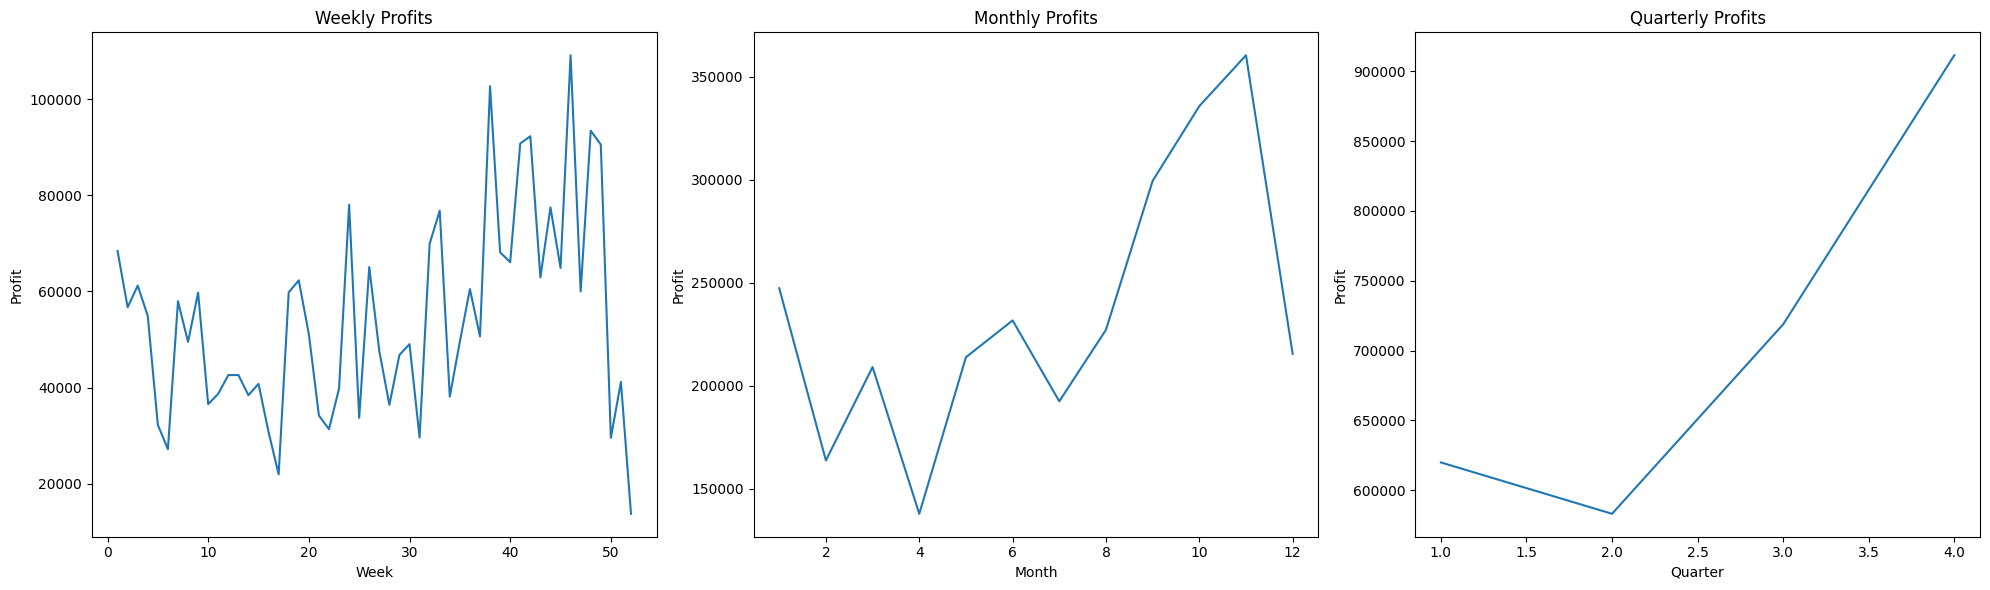

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(non_uk_weekly_profits.index, non_uk_weekly_profits.values)
plt.title('Weekly Profits')
plt.xlabel('Week')
plt.ylabel('Profit')

plt.subplot(1, 3, 2)
plt.plot(non_uk_monthly_profits.index, non_uk_monthly_profits.values)
plt.title('Monthly Profits')
plt.xlabel('Month')
plt.ylabel('Profit')

plt.subplot(1, 3, 3)
plt.plot(non_uk_quarterly_profits.index, non_uk_quarterly_profits.values)
plt.title('Quarterly Profits')
plt.xlabel('Quarter')
plt.ylabel('Profit')

plt.tight_layout()
plt.show()

**Ülke başına harcanan para**


Country
United Kingdom   13783449.7220
EIRE               590724.6350
Netherlands        532661.5900
Germany            426219.3910
France             328480.9600
Australia          164586.5200
Spain              104082.2250
Switzerland         99102.5600
Sweden              84353.8400
Belgium             63914.5200
Name: Total Amount Spent, dtype: float64


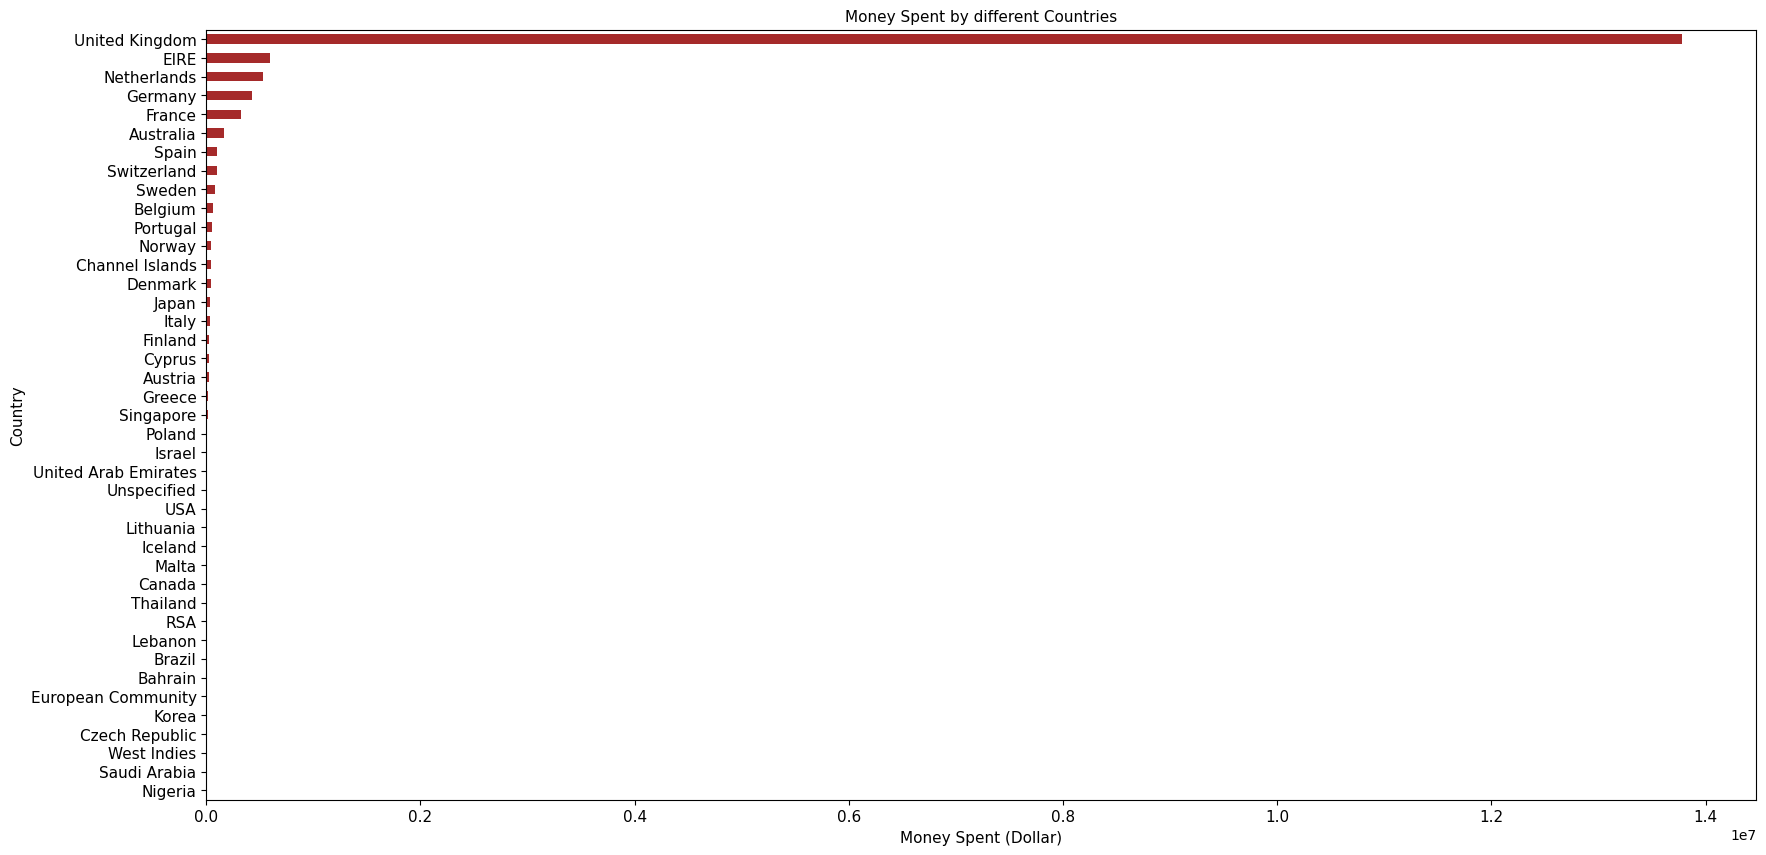

In [ ]:
df['Total Amount Spent'] = df['Quantity'] * df['Price']
country_amount_spent = df.groupby('Country')['Total Amount Spent'].sum().sort_values()
print(country_amount_spent.sort_values(ascending=False).head(10))
plt.subplots(figsize=(20,10))
country_amount_spent.plot(kind = 'barh', fontsize=11,color='#A52A2A')
plt.xlabel('Money Spent (Dollar)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Money Spent by different Countries', fontsize=11)
plt.show()

**Birleşik krallık dışındaki ülkelerin, ülke başına harcamasının görselleştirilmesi**

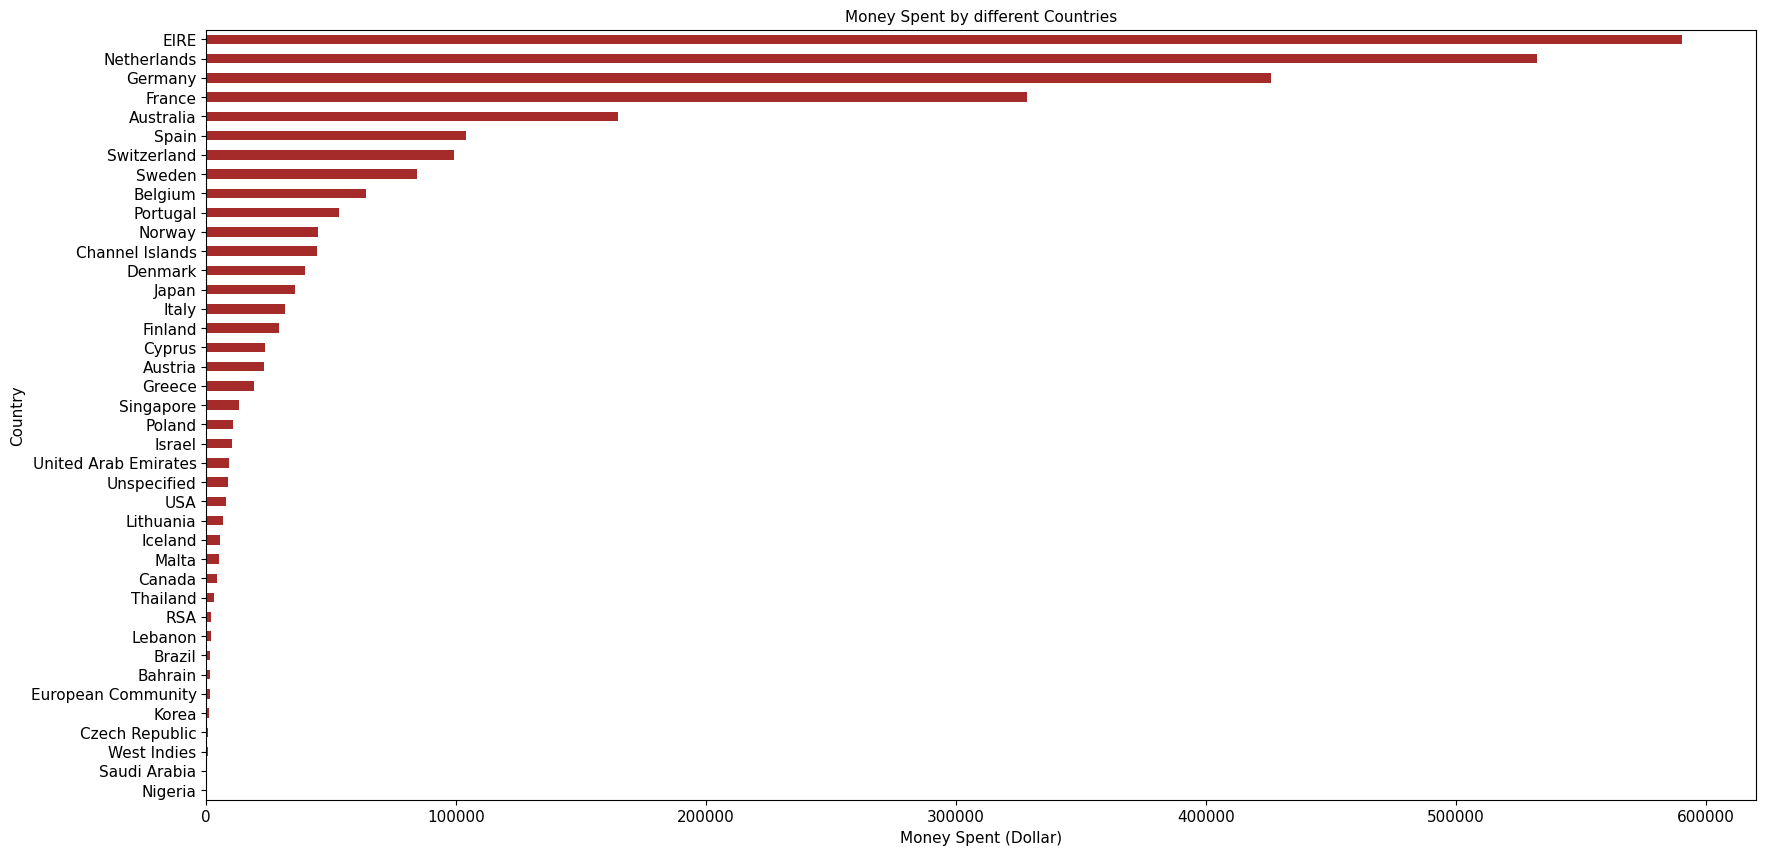

In [ ]:
country_amount_spent = df.groupby('Country')['Total Amount Spent'].sum().sort_values()
del country_amount_spent['United Kingdom']

plt.subplots(figsize=(20,10))
country_amount_spent.plot(kind = 'barh', fontsize=11,color='#A52A2A')
plt.xlabel('Money Spent (Dollar)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Money Spent by different Countries', fontsize=11)
plt.show()

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
today_date = dt.datetime(2011, 12, 11) #Analiz Tarihi

# Lifetime Veri Yapısının Hazırlanması
   ##### **recency**: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
   ##### **frequency:** tekrar eden toplam satın alma sayısı (frequency>1)
   ##### **monetary:** müşterinin harcamalarının toplamıdır.
   ##### **T:** Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
  

In [ ]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df.describe().T

cltv_df = cltv_df[(cltv_df['frequency'] > 1)] # Analiz için 1'den fazla alış veriş yapmış müsterileri seçiyoruz.

cltv_df["recency"] = cltv_df["recency"] / 7 # Hafta cinsinden


cltv_df["T"] = cltv_df["T"] / 7 # Hafta cinsinden




#**BG-NBD Modelinin Kurulması**

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.02)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.12, alpha: 8.92, b: 1.16, r: 1.38>

In [ ]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
14911.0000   3.4835
12748.0000   2.9538
17841.0000   1.8539
15311.0000   1.8264
13089.0000   1.7834
14606.0000   1.6906
14156.0000   1.3647
14646.0000   1.3300
18102.0000   1.2765
13694.0000   1.2625
dtype: float64

**1 hafta içinde en çok satın alma beklediğimiz 10 müşteri**

In [ ]:
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])
cltv_df["expected_purc_1_week"]



Customer ID
12346.0000   0.0090
12347.0000   0.1381
12348.0000   0.0834
12349.0000   0.0558
12352.0000   0.1695
              ...  
18281.0000   0.0316
18282.0000   0.1168
18283.0000   0.2253
18286.0000   0.0132
18287.0000   0.0896
Name: expected_purc_1_week, Length: 4255, dtype: float64

**1 ay içinde en çok satın alma beklediğimiz 10 müşteri**

In [ ]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()
top_10_customers = cltv_df.sort_values(by='expected_purc_1_month', ascending=False).head(10)
print(top_10_customers)

             recency        T  frequency  monetary  expected_purc_1_week  expected_purc_1_month  expected_purc_3_month
Customer ID                                                                                                           
14911.0000  105.2857 105.5714        398  709.3988                3.4835                13.9129                42.1916
12748.0000  104.8571 105.1429        336  156.9483                2.9538                11.7969                35.7727
17841.0000  105.0000 105.4286        211  335.4015                1.8539                 7.4044                22.4455
15311.0000  105.4286 105.5714        208  560.8082                1.8264                 7.2944                22.1089
13089.0000  104.8571 105.4286        203  575.0189                1.7834                 7.1228                21.5928
14606.0000  105.0000 105.2857        192  160.1871                1.6906                 6.7520                20.4649
14156.0000  104.0000 105.5714        156 1903.59

**1 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir ?**

In [ ]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1771.1063424827796

**3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?**

In [ ]:
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

**Tahmin Sonuçlarının Değerlendirilmesi**

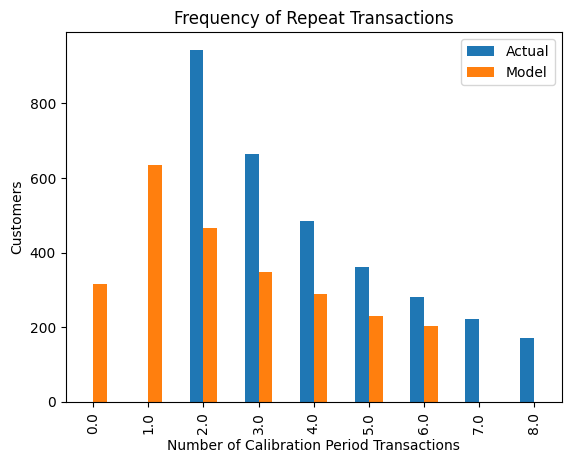

In [ ]:
plot_period_transactions(bgf)
plt.show()

**Satışları Etkileyen Faktörler**

*   Recency (son alışveriş tarihi)
*   Frequency (alışveriş sıklığı)
*   Monetary (ortalama harcama tutarı)

**Segmentlere ayrılan müşteriler için nasıl bir strateji izlenebilir ?**

A segment müşteriler için *VIP programları, kişiselleştirilmiş teklifler*,

B Segment müşteriler için *A segmentine yükseltmeye yönelik özel kampanyalar ve oyunlaştırma stratejileri*,

C Segment müşteriler için *alışveriş sıklığını artırmaya yönelik stratejiler*,

D Segment müşteriler için *yeniden aktivasyon kampanyaları uygulanabilir*.

#**GAMMA-GAMMA Modelinin Kurulması**


In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12357.0000,50.7143,55.5714,3,5824.8667,0.0644,0.2567,0.7636,6182.8322
12590.0000,0.0000,30.2857,2,4597.6125,0.0094,0.0376,0.1112,5035.2460
12415.0000,71.8571,75.4286,28,5003.3098,0.3429,1.3686,4.0834,5034.5651
14091.0000,6.2857,99.8571,2,4562.8450,0.0007,0.0029,0.0086,4997.1846
14088.0000,58.5714,60.2857,16,3986.0988,0.2480,0.9895,2.9487,4029.9276
18102.0000,105.4286,105.5714,145,3726.6687,1.2765,5.0983,15.2343,3731.1484
12753.0000,48.4286,51.8571,6,3571.5650,0.1178,0.4695,1.3971,3678.2984
12409.0000,69.4286,80.8571,7,3345.6129,0.0886,0.3538,1.0555,3430.9834
15749.0000,13.8571,47.5714,3,3231.7133,0.0259,0.1031,0.3063,3430.9068


#**BG-NBD ve GG modeli ile CLTV'nin hesaplanması.**

In [ ]:

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

cltv = cltv.reset_index()

cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
4139,18102.0000,105.4286,105.5714,145,3726.6687,1.2765,5.0983,15.2343,3731.1484,60500.9551
1652,14646.0000,105.0000,105.4286,151,3361.4186,1.3300,5.3117,15.8720,3365.3009,56852.9390
1290,14156.0000,104.0000,105.5714,156,1903.5948,1.3647,5.4505,16.2868,1905.7332,33036.4376
1840,14911.0000,105.2857,105.5714,398,709.3988,3.4835,13.9129,41.5740,709.7169,31405.3981
3682,17450.0000,61.2857,62.7143,51,3334.3318,0.7257,2.8956,8.6327,3345.7601,30734.4345
1247,14096.0000,13.8571,14.5714,17,3163.4965,0.7707,3.0600,9.0231,3196.2592,30653.2109
51,12415.0000,71.8571,75.4286,28,5003.3098,0.3429,1.3686,4.0834,5034.5651,21877.9581
949,13694.0000,104.4286,105.1429,143,1338.7443,1.2625,5.0421,15.0662,1340.3929,21494.7520
3728,17511.0000,104.8571,105.4286,60,2924.4313,0.5350,2.1367,6.3846,2932.9545,19931.0676
3114,16684.0000,104.0000,104.7143,55,2513.8125,0.4943,1.9742,5.8988,2521.8167,15833.1480


#**CLTV'ye Göre Segmentlerin Oluşturulması**

**A Segmenti:** En yüksek CLV, en sık alışveriş, en yüksek harcama

**B Segmenti:** Orta-yüksek CLV

**C Segmenti:** Orta-düşük CLV

**D Segmenti:** En düşük CLV, en az sıklıkta alışveriş, en düşük harcama

In [ ]:
cltv_final

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(50)

cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})


Customer ID                          recency                        T                    frequency                monetary                      expected_purc_1_week                 expected_purc_1_month                 expected_purc_3_month                  expected_average_profit                        clv                       
              count       mean           sum   count    mean        sum count    mean        sum     count    mean    sum    count     mean         sum                count   mean      sum                 count   mean      sum                 count   mean       sum                   count     mean         sum count      mean          sum
segment                                                                                                                                                                                                                                                                                                                                            
D              1064 15423.7444 16410864.0000    1064 28.5749 30403.7143  1064 81.4382 86650.2857      1064  3.9051   4155     1064 249.3951 265356.3925                 1064 0.0166  17.6238                  1064 0.0661  70.2951                  1064 0.1968  209.3993                    1064 267.5411 284663.7452  1064   36.0421   38348.7419
C              1064 15483.2660 16474195.0000    1064 59.3801 63180.4286  1064 75.9791 80841.7143      1064  4.5310   4821     1064 265.2167 282190.5807                 1064 0.0624  66.3717                  1064 0.2487 264.5809                  1064 0.7399  787.2246                    1064 281.6652 299691.7865  1064  182.8953  194600.6077
B              1063 15257.6886 16218923.0000    1063 63.2758 67262.1429  1063 71.7998 76323.1429      1063  7.3509   7814     1063 359.9328 382608.5543                 1063 0.1071 113.8040                  1063 0.4266 453.4848                  1063 1.2683 1348.2477                    1063 375.7033 399372.5857  1063  417.4458  443744.8580
A              1064 15074.6090 16039384.0000    1064 64.2994 68414.5714  1064 68.4131 72791.5714      1064 17.4398  18556     1064 586.9060 624468.0026                 1064 0.2319 246.6960                  1064 0.9236 982.7456                  1064 2.7448 2920.4272                    1064 603.7014 642338.2997  1064 1704.7074 1813808.6966

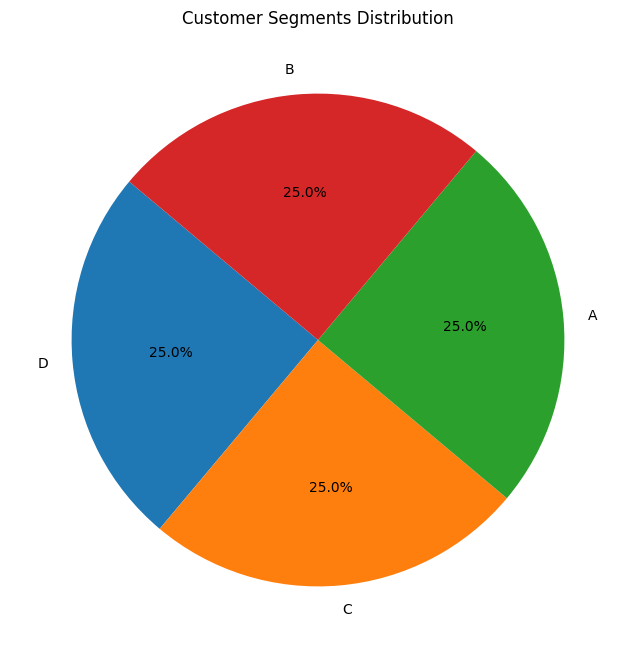

In [ ]:
# Müşteri Segmentleri
segment_counts = cltv_final['segment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Segments Distribution')
plt.show()

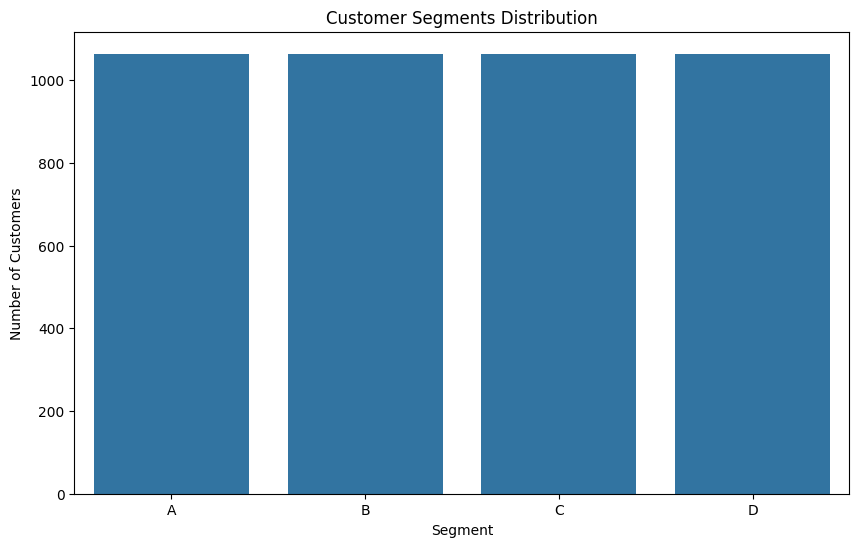

In [ ]:
# Segmentlerin sayısal dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(x='segment', data=cltv_final, order=['A', 'B', 'C', 'D'])
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

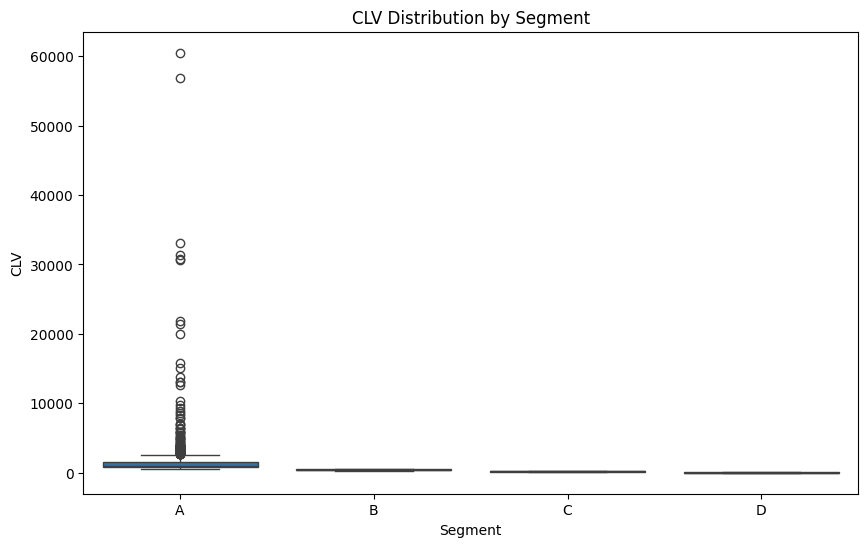

In [ ]:
# Segmentlere göre CLV dağılımını gösteren box plot

plt.figure(figsize=(10, 6))
sns.boxplot(x='segment', y='clv', data=cltv_final, order=['A', 'B', 'C', 'D'])
plt.title('CLV Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('CLV')
plt.show()

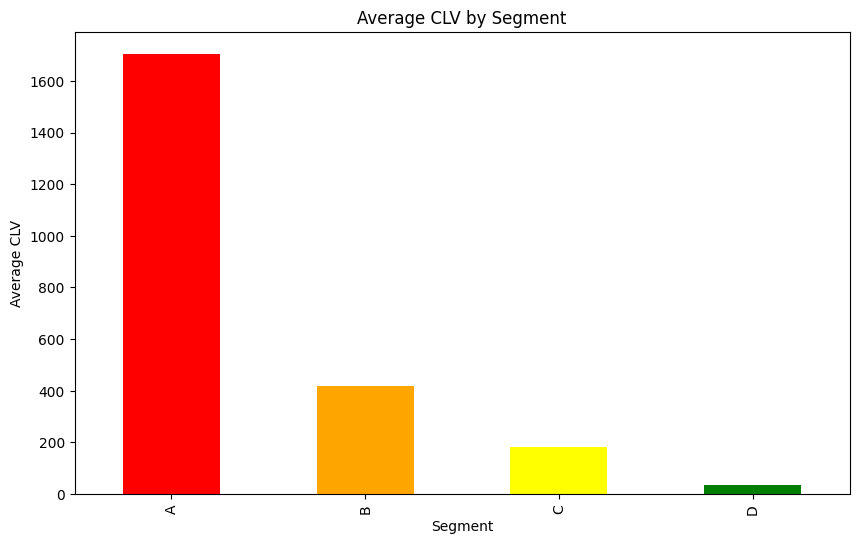

In [ ]:
# Her segmentin ortalama CLV değerlerini gösteren bar plot
segment_means = cltv_final.groupby("segment")["clv"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
segment_means.plot(kind='bar', color=['red', 'orange', 'yellow', 'green'])
plt.title('Average CLV by Segment')
plt.xlabel('Segment')
plt.ylabel('Average CLV')
plt.show()

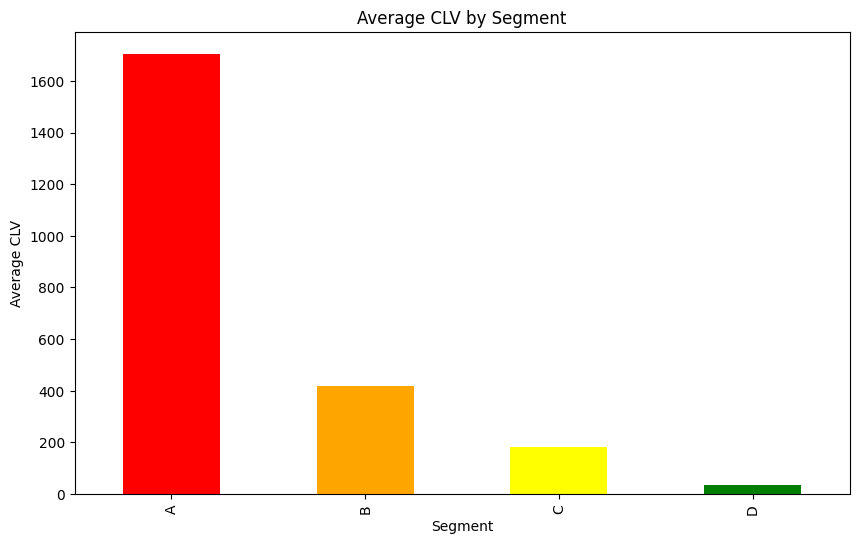

In [ ]:
# Her segmentin ortalama CLV değerlerini gösteren bar plot
segment_means = cltv_final.groupby("segment")["clv"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
segment_means.plot(kind='bar', color=['red', 'orange', 'yellow', 'green'])
plt.title('Average CLV by Segment')
plt.xlabel('Segment')
plt.ylabel('Average CLV')
plt.show()

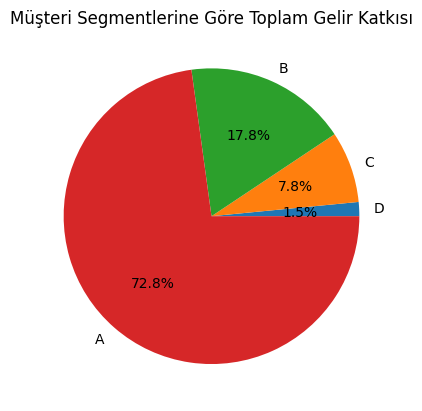

In [ ]:
segment_sums = cltv_final.groupby('segment')['clv'].sum()
segment_sums.plot(kind='pie', autopct='%1.1f%%')
plt.title('Müşteri Segmentlerine Göre Toplam Gelir Katkısı')
plt.ylabel('')
plt.show()

In [ ]:
df_final = cltv_final.to_csv("cltv_prediction.csv")


In [ ]:
df_final = pd.read_csv("/content/cltv_prediction.csv")

In [ ]:
df_final

,Unnamed: 0,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,0,12346.0000,57.1429,103.7143,12,58.6750,0.0090,0.0359,0.1071,59.8502,6.8248,D
1,1,12347.0000,57.4286,57.8571,8,704.1650,0.1381,0.5510,1.6409,720.2151,1257.4223,A
2,2,12348.0000,51.7143,62.7143,5,398.3720,0.0834,0.3326,0.9908,413.4323,435.8275,B
3,3,12349.0000,81.4286,84.2857,4,946.6250,0.0558,0.2225,0.6638,990.4172,699.6365,A
4,4,12352.0000,50.8571,56.1429,10,209.8940,0.1695,0.6760,2.0133,213.9718,458.3442,B
...,...,...,...,...,...,...,...,...,...,...,...,...
4250,4250,18281.0000,56.7143,82.5714,2,100.5700,0.0316,0.1260,0.3754,112.1469,44.8017,D
4251,4251,18282.0000,16.8571,18.1429,2,89.0250,0.1168,0.4636,1.3650,99.5081,144.3427,C
4252,4252,18283.0000,93.4286,94.1429,22,124.3932,0.2253,0.8994,2.6860,125.5511,358.9230,B
4253,4253,18286.0000,35.2857,103.4286,2,641.6850,0.0132,0.0527,0.1572,704.5280,117.8652,C


# Cevaplar


**Segment Özellikleri:**

* A Segmenti: En yüksek CLV, en sık alışveriş, en yüksek harcama

* B Segmenti: Orta-yüksek CLV

* C Segmenti: Orta-düşük CLV

* D Segmenti: En düşük CLV, en az sıklıkta alışveriş, en düşük harcama



**Satışları Etkileyen Faktörler**

* Recency (son alışveriş tarihi)
* Frequency (alışveriş sıklığı)
* Monetary (ortalama harcama tutarı)



**Segmentlere ayrılan müşteriler için nasıl bir strateji izlenebilir ?**

* A segment müşteriler için VIP programları, kişiselleştirilmiş teklifler,

* B Segment müşteriler için A segmentine yükseltmeye yönelik özel kampanyalar ve oyunlaştırma stratejileri,

* C Segment müşteriler için alışveriş sıklığını artırmaya yönelik stratejiler,

* D Segment müşteriler için yeniden aktivasyon kampanyaları uygulanabilir.

# Genel Bakış ve Kapanış

**Müşteri Segmentasyonu ve Satış Tahmini Analizi**

Bu projede, bir e-ticaret şirketinin müşteri verilerini kullanarak müşteri segmentasyonu ve satış tahmini analizi gerçekleştirdik. Amaç, müşterileri daha iyi anlamak, pazarlama stratejilerini optimize etmek ve gelecekteki satışları tahmin etmekti.

**Veri Seti ve Ön İşleme**

Online Retail II veri setini kullandık. Veri setinde eksik değerler, iadeler ve aykırı değerler gibi sorunlar vardı. Bu sorunları gidermek için veri temizleme ve ön işleme adımları uyguladık.

**Analiz ve Bulgular**

* En Çok Satılan Ürünler: En çok satılan ürünleri belirledik ve bu ürünlere odaklanarak stok yönetimi ve pazarlama stratejilerini optimize edebiliriz.
* En Çok İade Edilen Ürünler: En çok iade edilen ürünleri analiz ederek ürün kalitesi, müşteri memnuniyeti ve iade süreçlerinde iyileştirmeler yapabiliriz.
* Ülke Bazında Satışlar: Ülkelere göre satışları inceleyerek hedef pazarları belirleyebilir ve pazarlama stratejilerini ülkeye özgü hale getirebiliriz.
* Haftalık, Aylık ve Üç Aylık Karlar: Zamana bağlı karlılığı analiz ederek sezonluk trendleri belirleyebilir ve buna göre kampanyalar planlayabiliriz.



**İş Değeri**


Bu analizler sonucunda elde ettiğimiz bilgiler, e-ticaret şirketine aşağıdaki konularda yardımcı olabilir:

* **Müşteri sadakatini artırmak**

* **Satışları ve karlılığı artırmak**

* **Operasyonel verimliliği artırmak**

* **Müşteri deneyimini iyileştirmek**



**Öneriler**

* **Müşteri Segmentasyonu:** RFM analizi gibi yöntemlerle müşterileri segmentlere ayırarak hedef kitlelere özel pazarlama stratejileri geliştirebiliriz.

* **Satış Tahmini:** Zaman serisi analizi gibi yöntemlerle gelecekteki satışları tahmin ederek stok yönetimi ve kampanya planlamasını optimize edebiliriz.

* **Ürün Önerileri:** Müşteri davranışlarına göre kişiselleştirilmiş ürün önerileri sunarak satışları artırabiliriz.


**Gelecekteki Çalışmalar**

Daha gelişmiş makine öğrenmesi modelleri kullanarak müşteri davranışlarını daha detaylı analiz edebiliriz.
Gerçek zamanlı veri analizi ile müşteri ihtiyaçlarına daha hızlı yanıt verebiliriz.

A/B testleri ile farklı pazarlama stratejilerinin etkisini ölçebiliriz.
Bu analizler, e-ticaret şirketinin müşterilerini daha iyi anlamasına ve veriye dayalı kararlar alarak işini büyütmesine yardımcı olabilir.